In [5]:
pip install gdcm
pip install pylibjpeg 
pip install pylibjpeg-libjpeg

SyntaxError: invalid syntax (2528679311.py, line 1)

In [4]:
import pydicom

# Path to the DICOM file
dicom_path = os.path.join(STUDY_PATH, "25033115", "27210000", "19641418")

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_path)

# Display the image
plt.imshow(dicom_data.pixel_array, cmap='gray')
plt.title("DICOM Image")
plt.axis('off')
plt.show()

RuntimeError: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1

In [5]:
# Créer un GIF animé avec une meilleure qualité
images[0].save(
    output_gif_path,
    save_all=True,
    append_images=images[1:],
    duration=500,
    loop=0,
    optimize=False  # Désactiver l'optimisation pour une meilleure qualité
)

print(f"GIF animé créé avec une meilleure qualité : {output_gif_path}")


NameError: name 'images' is not defined

In [6]:
import os
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pylibjpeg as jpeg
%matplotlib inline
from scipy.signal import convolve
from scipy.linalg import lstsq


In [7]:
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","meningiome_AZ","test_perf","DICOM")

In [8]:
import nibabel as nib
import numpy as np

import matplotlib.pyplot as plt

# Chemin vers le fichier NIfTI 4D
nifti_path = os.path.join(STUDY_PATH, "25033115", "27210000", "merged_image.nii.gz")

# Charger le fichier NIfTI
nifti_img = nib.load(nifti_path)
nifti_data = nifti_img.get_fdata()

# Vérifier les dimensions des données (doit être 4D : x, y, z, t)
print(f"Dimensions des données NIfTI : {nifti_data.shape}")

Dimensions des données NIfTI : (512, 512, 509, 9)


In [9]:
nifti_data_perf=nifti_data[:,:,125:130,:]  # Limiter à 10 volumes pour l'exemple
nifti_data_aif=nifti_data[:,:,210:214,:]  # Premier volume comme AIF

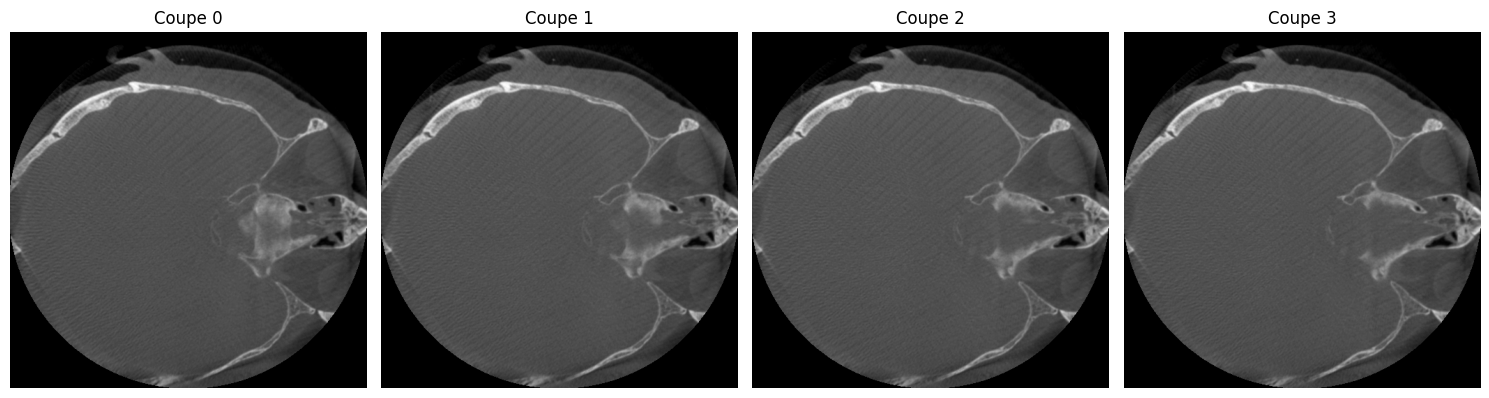

In [10]:
# Visualiser toutes les coupes axiales de nifti_data_perf pour le premier temps (t=0)
num_slices = nifti_data_aif.shape[2]
plt.figure(figsize=(15, num_slices * 2))

for i in range(num_slices):
    plt.subplot(1, num_slices, i + 1)
    plt.imshow(nifti_data_aif[:, :, i, 2], cmap='gray')
    plt.title(f"Coupe {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

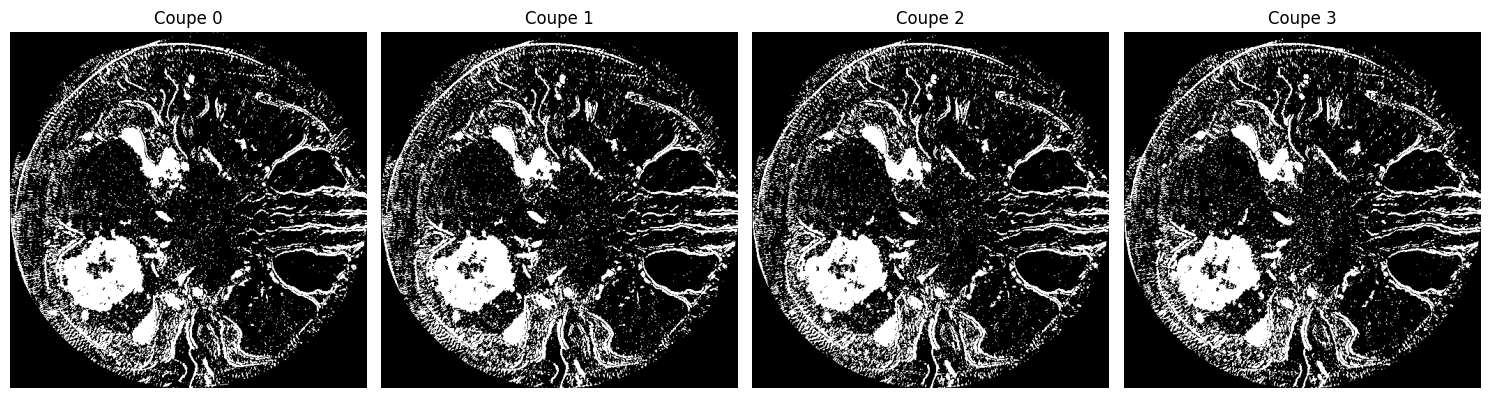

In [25]:
# Visualiser toutes les coupes axiales de nifti_data_perf pour le premier temps (t=0)
num_slices = nifti_data_aif.shape[2]
plt.figure(figsize=(15, num_slices * 2))

std_img = np.std(nifti_data_perf, axis=3)

for i in range(num_slices):
    plt.subplot(1, num_slices, i + 1)
    plt.imshow(std_img[:, :, i]>50, cmap='gray')
    plt.title(f"Coupe {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

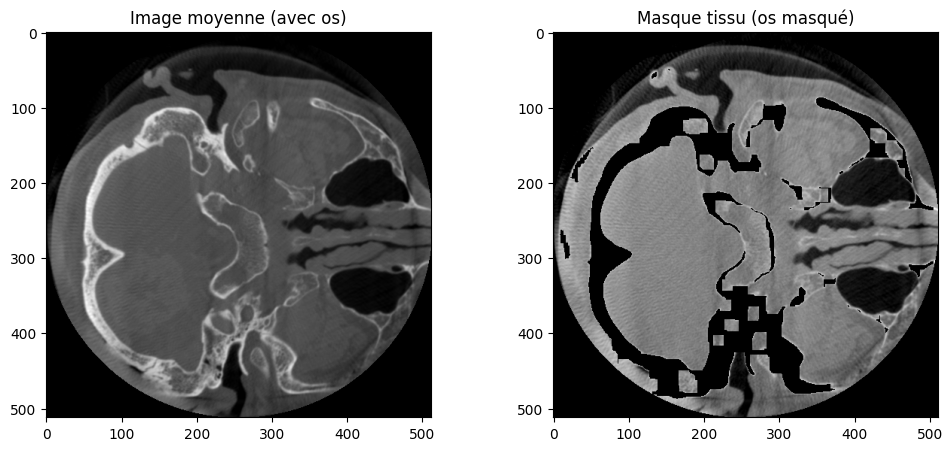

In [16]:
from scipy.ndimage import binary_closing

# 1. Calculer la moyenne temporelle pour obtenir une image 3D représentative
mean_img = np.mean(nifti_data_perf, axis=3)

# 2. Définir un seuil pour l'os (à ajuster selon tes données, ex: > 800 HU)
bone_threshold = 1600
bone_mask = mean_img > bone_threshold

# 3. Appliquer une fermeture morphologique pour combler les petits trous dans le masque osseux
bone_mask_closed = binary_closing(bone_mask, structure=np.ones((14,14,3)))

# 4. Créer un masque inverse pour ne garder que les tissus non osseux
brain_mask = ~bone_mask_closed

# 5. Appliquer ce masque à toutes les images temporelles
nifti_data_perf_masked = nifti_data_perf * brain_mask[..., np.newaxis]

# 6. Visualisation pour vérifier le résultat
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(mean_img[:, :, mean_img.shape[2]//2], cmap='gray')
plt.title("Image moyenne (avec os)")
plt.subplot(1,2,2)
plt.imshow(nifti_data_perf_masked[:, :, mean_img.shape[2]//2,1], cmap='gray')
plt.title("Masque tissu (os masqué)")
plt.show()

tentative de création un masque du meningiome

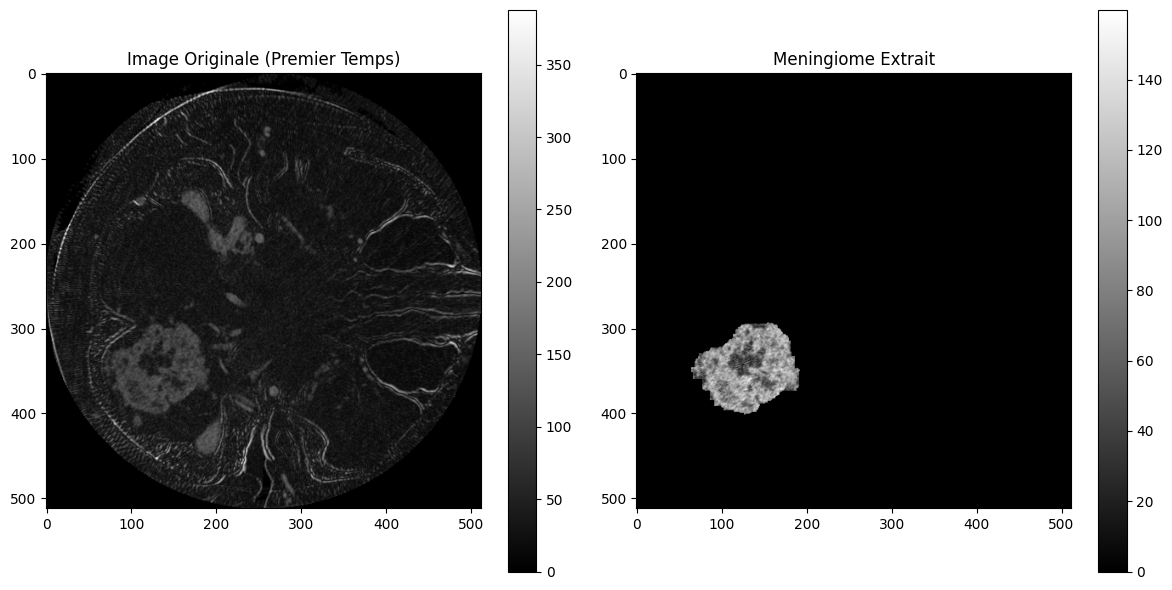

In [40]:
from scipy.ndimage import binary_fill_holes, label
from skimage.morphology import remove_small_objects
from scipy.ndimage import binary_closing

# Extraire la première image temporelle
first_timepoint = std_img#nifti_data[:, :, :, 0]

# Appliquer un seuillage pour segmenter la boîte crânienne
threshold_value = np.percentile(first_timepoint, 90)  # Ajustez ce seuil si nécessaire
binary_mask = first_timepoint > threshold_value

# Remplir les trous dans le masque binaire
filled_mask = binary_fill_holes(binary_mask)

# Supprimer les petits objets pour garder uniquement les grandes structures (comme le cerveau)
cleaned_mask = remove_small_objects(filled_mask, min_size=500)  # Ajustez min_size si nécessaire

# Identifier la plus grande composante connexe (le cerveau)
labeled_mask, num_features = label(cleaned_mask)
component_sizes = np.bincount(labeled_mask.ravel())
component_sizes[0] = 0  # Ignorer le fond
largest_component = np.argmax(component_sizes)
brain_mask = labeled_mask == largest_component

# Appliquer une fermeture morphologique pour combler les petits trous dans le masque du cerveau
brain_mask = binary_closing(brain_mask, structure=np.ones((50, 50, 1)))

# Appliquer le masque pour extraire le cerveau
brain_extracted = first_timepoint * brain_mask

# Afficher le résultat
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(first_timepoint[:, :, first_timepoint.shape[2] // 4], cmap='gray')
plt.title("Image Originale (Premier Temps)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(brain_extracted[:, :, first_timepoint.shape[2] // 4], cmap='gray')
plt.title("Meningiome Extrait")
plt.colorbar()

plt.tight_layout()
plt.show()

AIF "globale" 

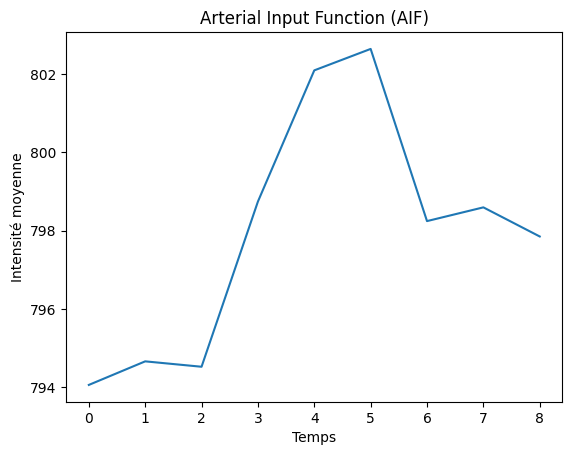

In [32]:
# Calculer l'AIF (exemple simple : moyenne des intensités dans une région d'intérêt (ROI))
# Définir une ROI (par exemple, une région arbitraire dans l'image)
roi_x, roi_y, roi_z = slice(30, 40), slice(30, 40), slice(5, 6)  # Exemple de ROI
#roi_data = nifti_data[roi_x, roi_y, roi_z, :]
roi_data = nifti_data_aif#[roi_x, roi_y, roi_z, :]

# Calculer l'AIF comme la moyenne des intensités dans la ROI pour chaque point temporel
aif = np.mean(roi_data, axis=(0, 1, 2))

# Afficher l'AIF
plt.plot(aif)
plt.title("Arterial Input Function (AIF)")
plt.xlabel("Temps")
plt.ylabel("Intensité moyenne")
plt.show()

AIF automatique

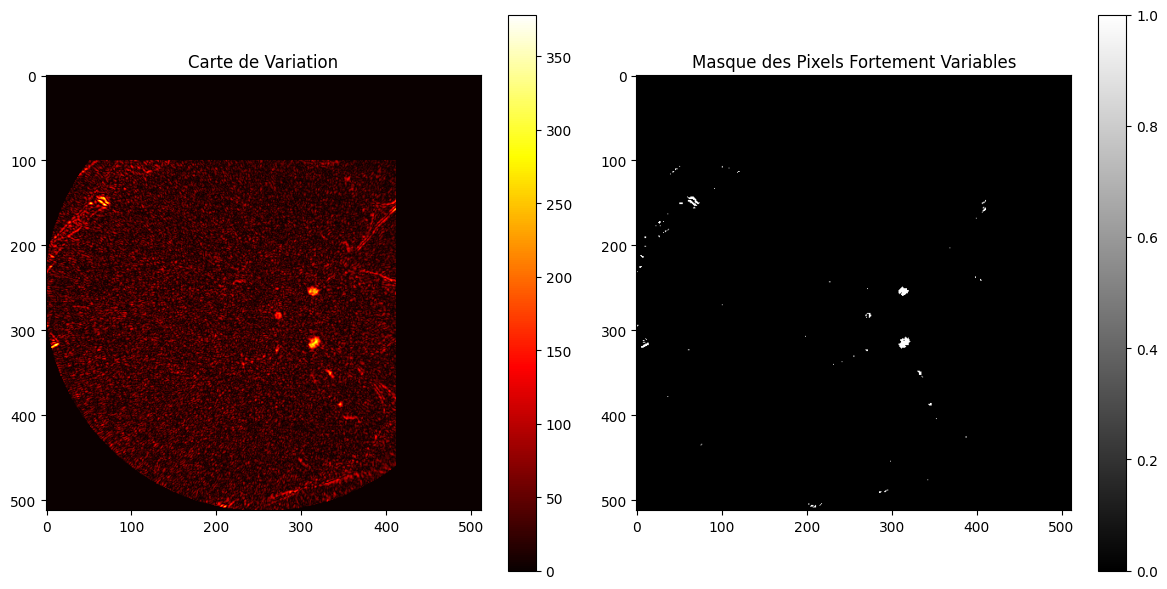

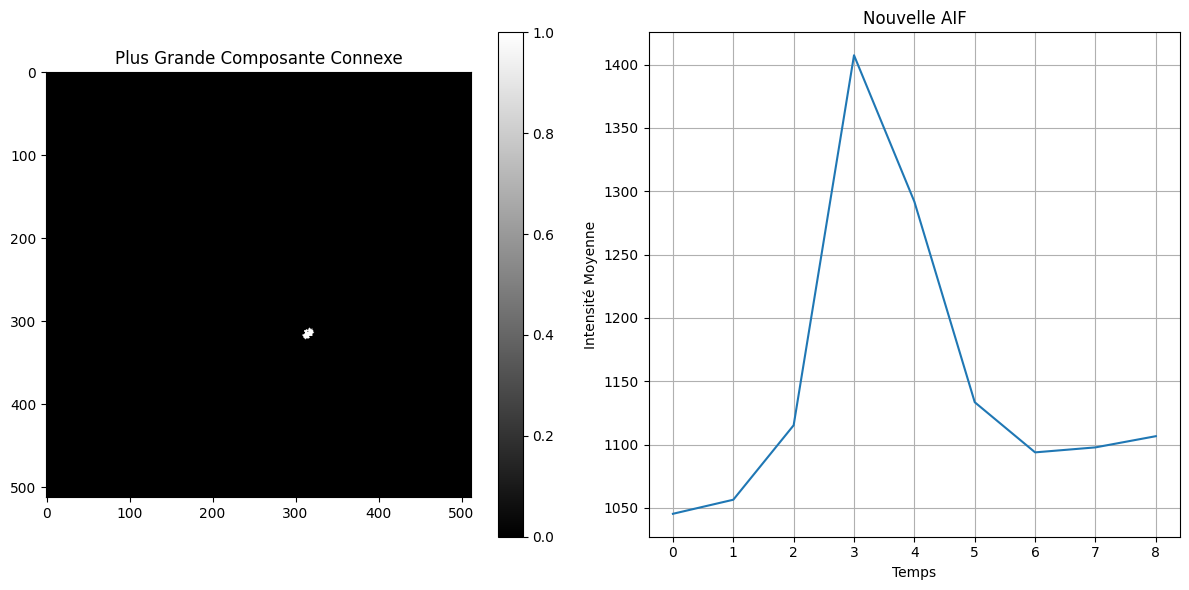

In [41]:
# Calculer la moyenne des intensités pour les temps 0, 1, 2 et 4, 5, 6
mean_early = np.mean(nifti_data_aif[:, :, :, 0:1], axis=3)
mean_late = np.mean(nifti_data_aif[:, :, :, 2:4], axis=3)

mean_early[0:100,:,:]=0
mean_late[0:100,:,:]=0
mean_early[:,412:,:]=0
mean_late[:,412:,:]=0

# Calculer la différence absolue entre les deux moyennes
variation_map = np.abs(mean_early - mean_late)

# Créer un masque pour les pixels qui varient fortement (par exemple, seuil > 10)
threshold = 150  # Ajustez ce seuil selon vos besoins
mask = variation_map > threshold

# Afficher la carte de variation et le masque
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(variation_map[:, :, nifti_data_aif.shape[2] // 2], cmap='hot')
plt.title("Carte de Variation")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, nifti_data_aif.shape[2] // 2], cmap='gray')
plt.title("Masque des Pixels Fortement Variables")
plt.colorbar()

plt.tight_layout()
plt.show()

from scipy.ndimage import label

# Identifier les composantes connexes dans le masque
labeled_mask, num_features = label(mask)

# Trouver la taille de chaque composante connexe
component_sizes = np.bincount(labeled_mask.ravel())

# Ignorer la composante de fond (index 0)
component_sizes[0] = 0

# Identifier la plus grande composante connexe
largest_component = np.argmax(component_sizes)

# Créer un nouveau masque ne contenant que la plus grande composante connexe
largest_component_mask = labeled_mask == largest_component

# Extraire les données de la région correspondant à la plus grande composante connexe
region_data = nifti_data_aif[largest_component_mask, :]

# Calculer l'AIF pour cette région (moyenne des variations du signal dans le temps)
aif_new = np.mean(region_data, axis=0)

# Afficher la région et la nouvelle AIF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(largest_component_mask[:, :, nifti_data_aif.shape[2] // 2], cmap='gray')
plt.title("Plus Grande Composante Connexe")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(aif_new)
plt.title("Nouvelle AIF")
plt.xlabel("Temps")
plt.ylabel("Intensité Moyenne")
plt.grid()

plt.tight_layout()
plt.show()

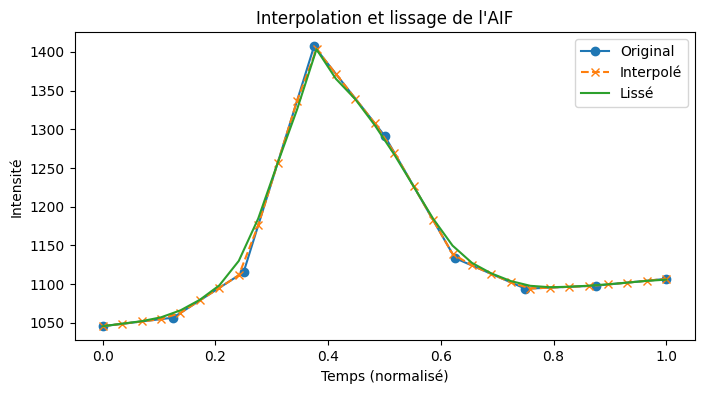

In [53]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

# Interpoler aif_new sur 30 points temporels
n_points = 30
x_old = np.linspace(0, 1, len(aif_new))
x_new = np.linspace(0, 1, n_points)

interp_func = interp1d(x_old, aif_new, kind='linear')
aif_new_interp = interp_func(x_new)

# Appliquer un smoothing gaussien
# Appliquer un smoothing gaussien tout en conservant les min/max originaux
aif_new_smooth = gaussian_filter1d(aif_new_interp, sigma=1)

# Remplacer les min et max par les valeurs originales interpolées
min_idx = np.argmin(aif_new_interp)
max_idx = np.argmax(aif_new_interp)
aif_new_smooth[min_idx] = aif_new_interp[min_idx]
aif_new_smooth[max_idx] = aif_new_interp[max_idx]

plt.figure(figsize=(8,4))
plt.plot(x_old, aif_new, 'o-', label='Original')
plt.plot(x_new, aif_new_interp, 'x--', label='Interpolé')
plt.plot(x_new, aif_new_smooth, '-', label='Lissé')
plt.legend()
plt.title("Interpolation et lissage de l'AIF")
plt.xlabel("Temps (normalisé)")
plt.ylabel("Intensité")
plt.show()

In [54]:
# Fonction pour effectuer la déconvolution
def deconvolve_aif(aif, signal):
    # Construire une matrice de convolution
    n_timepoints = len(aif)
    conv_matrix = np.zeros((n_timepoints, n_timepoints))
    for i in range(n_timepoints):
        conv_matrix[i:, i] = aif[:n_timepoints - i]
    
    # Résoudre le problème de moindres carrés
    residue, _, _, _ = lstsq(conv_matrix, signal)
    return residue

# Fonction pour effectuer la convolution
def convolve_aif(aif, residue):
    return np.convolve(aif, residue, mode='full')[:len(aif)]

In [ ]:
# Vérification de la convolution après la déconvolution
for x in range(nifti_data_perf.shape[0]):
    for y in range(nifti_data_perf.shape[1]):
        for z in range(nifti_data_perf.shape[2]):
            # Extraire le signal temporel pour le voxel
            signal = nifti_data_perf[x, y, z, :]
            
            # Déconvolution pour obtenir la fonction résiduelle
            residue = deconvolve_aif(aif*1000, signal)
            
            # Convolution de l'AIF avec la fonction résiduelle
            recon_signal = convolve_aif(aif*1000, residue)
            
            # Vérification si le signal reconstruit est proche du signal original
            if not np.allclose(signal, recon_signal, atol=1e-3):
                print(f"Mismatch at voxel ({x}, {y}, {z})")

# Interpolation du volume de perf

In [57]:
from scipy.interpolate import interp1d

# Interpoler la 4ème dimension (temps) de nifti_data_perf sur le même nombre de points que aif_new_interp
n_points = len(x_new)  # nombre de points interpolés (même que aif_new_interp)
nifti_shape = nifti_data_perf.shape
x_orig = np.linspace(0, 1, nifti_shape[3])

# Créer un tableau pour stocker les données interpolées
nifti_data_perf_interp = np.zeros(nifti_shape[:3] + (n_points,))

for x in range(nifti_shape[0]):
    for y in range(nifti_shape[1]):
        for z in range(nifti_shape[2]):
            signal = nifti_data_perf[x, y, z, :]
            interp_func = interp1d(x_orig, signal, kind='linear', fill_value="extrapolate")
            nifti_data_perf_interp[x, y, z, :] = interp_func(x_new)

nifti_data_perf_interp.shape  # Vérifier la nouvelle forme des données

(512, 512, 5, 30)

In [58]:
# Initialiser la carte du signal reconstruit
residue_signal_map = np.zeros(nifti_data_perf_interp.shape)
recon_signal_map = np.zeros(nifti_data_perf_interp.shape)
diff_signal_map = np.zeros(nifti_data_perf_interp.shape[:3])

# Calculer le signal reconstruit voxel par voxel
for x in range(nifti_data_perf_interp.shape[0]):
    for y in range(nifti_data_perf_interp.shape[1]):
        for z in range(nifti_data_perf_interp.shape[2]):
            # Extraire le signal temporel pour le voxel
            signal = nifti_data_perf_interp[x, y, z, :]
            
            # Déconvolution pour obtenir la fonction résiduelle
            residue = deconvolve_aif(aif_new_smooth, signal)
            
            # Convolution de l'AIF avec la fonction résiduelle pour reconstruire le signal
            recon_signal = convolve_aif(aif_new_smooth, residue)
            
            residue_signal_map[x, y, z,:] = residue
            recon_signal_map[x, y, z,:] = recon_signal

            # Stocker la somme des différences entre le signal reconstruit et le signal original
            diff_signal_map[x, y, z] = np.sum(np.abs(signal - recon_signal))

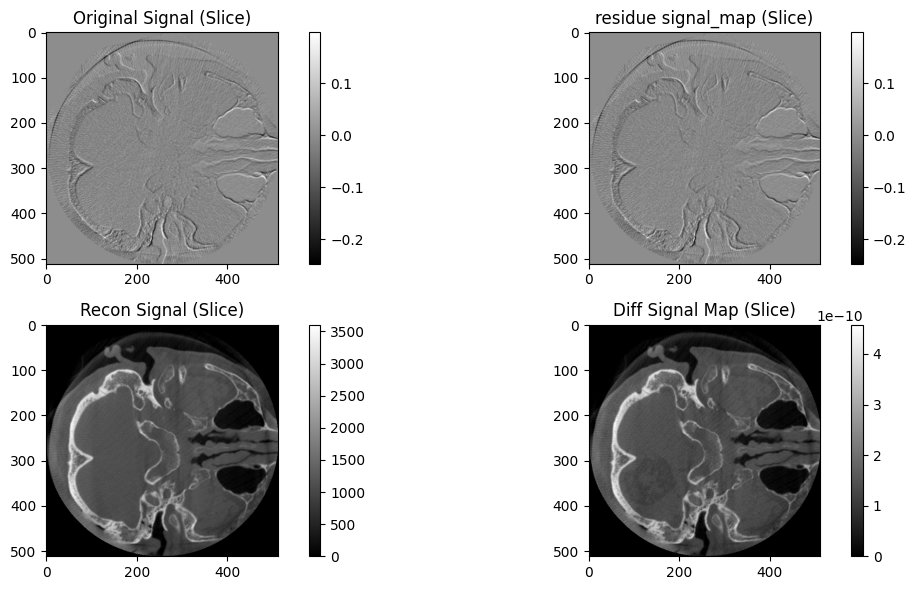

In [59]:
# Afficher les cartes pour comparer le signal reconstruit et les données originales
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(residue_signal_map[:, :, nifti_data_perf_interp.shape[2] // 2, 5], cmap='gray')
plt.title("Original Signal (Slice)")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(residue_signal_map[:, :, nifti_data_perf_interp.shape[2] // 2, 5], cmap='gray')
plt.title("residue signal_map (Slice)")
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(recon_signal_map[:, :, nifti_data_perf_interp.shape[2] // 2, 5], cmap='gray')
plt.title("Recon Signal (Slice)")
plt.colorbar()


plt.subplot(2, 2, 4)
plt.imshow(diff_signal_map[:, :, nifti_data_perf_interp.shape[2] // 2], cmap='gray')
plt.title("Diff Signal Map (Slice)")
plt.colorbar()

plt.tight_layout()
plt.show()

# Création des cartes parametriques 

In [ ]:
from scipy.ndimage import gaussian_filter

# Smoothing spatial (sigma à ajuster selon la résolution)
sigma = 2  # Par exemple, 2 voxels

cbv_map_smooth = gaussian_filter(cbv_map, sigma=sigma)
cbf_map_smooth = gaussian_filter(cbf_map, sigma=sigma)
mtt_map_smooth = gaussian_filter(mtt_map, sigma=sigma)
ttp_map_smooth = gaussian_filter(ttp_map, sigma=sigma)

# Sauvegarder chaque carte paramétrique lissée dans un fichier NIfTI séparé

cbv_img = nib.Nifti1Image(cbv_map_smooth, affine=nifti_img.affine, header=nifti_img.header)
cbv_path = os.path.join(os.path.dirname(nifti_path), "cbv_map_20250702.nii.gz")
nib.save(cbv_img, cbv_path)
print(f"CBV map sauvegardée dans : {cbv_path}")

cbf_img = nib.Nifti1Image(cbf_map_smooth, affine=nifti_img.affine, header=nifti_img.header)
cbf_path = os.path.join(os.path.dirname(nifti_path), "cbf_map_20250702.nii.gz")
nib.save(cbf_img, cbf_path)
print(f"CBF map sauvegardée dans : {cbf_path}")

mtt_img = nib.Nifti1Image(mtt_map_smooth, affine=nifti_img.affine, header=nifti_img.header)
mtt_path = os.path.join(os.path.dirname(nifti_path), "mtt_map_20250702.nii.gz")
nib.save(mtt_img, mtt_path)
print(f"MTT map sauvegardée dans : {mtt_path}")

ttp_img = nib.Nifti1Image(ttp_map_smooth, affine=nifti_img.affine, header=nifti_img.header)
ttp_path = os.path.join(os.path.dirname(nifti_path), "ttp_map_20250702.nii.gz")
nib.save(ttp_img, ttp_path)
print(f"TTP map sauvegardée dans : {ttp_path}")


CBV map sauvegardée dans : /NAS/dumbo/protocoles/meningiome_AZ/test_perf/DICOM/25033115/27210000/cbv_map_20250702.nii.gz
CBF map sauvegardée dans : /NAS/dumbo/protocoles/meningiome_AZ/test_perf/DICOM/25033115/27210000/cbf_map_20250702.nii.gz
MTT map sauvegardée dans : /NAS/dumbo/protocoles/meningiome_AZ/test_perf/DICOM/25033115/27210000/mtt_map_20250702.nii.gz
TTP map sauvegardée dans : /NAS/dumbo/protocoles/meningiome_AZ/test_perf/DICOM/25033115/27210000/ttp_map_20250702.nii.gz


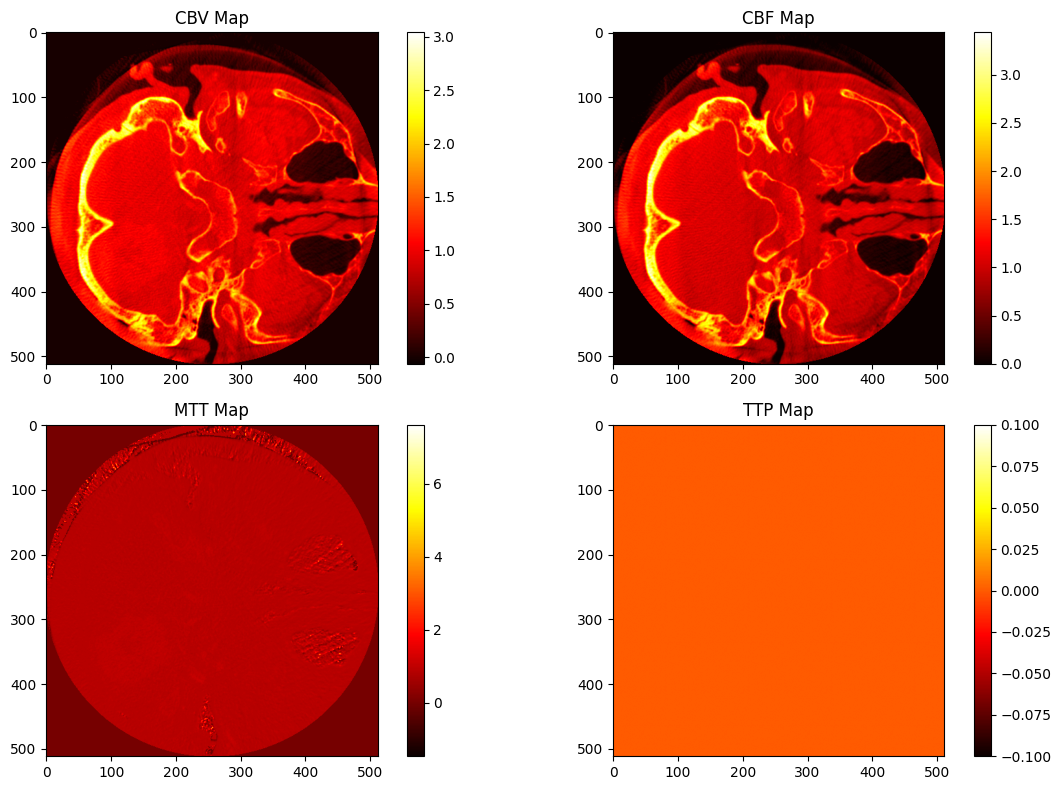

In [ ]:

# Afficher les cartes de perfusion
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(cbv_map[:, :, nifti_data_perf_interp.shape[2] // 2], cmap='hot')
plt.title("CBV Map")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(cbf_map[:, :, nifti_data_perf_interp.shape[2] // 2], cmap='hot')
plt.title("CBF Map")
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(mtt_map[:, :, nifti_data_perf_interp.shape[2] // 2], cmap='hot')
plt.title("MTT Map")
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(ttp_map[:, :, nifti_data_perf_interp.shape[2] // 2], cmap='hot')
plt.title("TTP Map")
plt.colorbar()

plt.tight_layout()
plt.savefig("perfMeningiome3.jpg")
plt.show()